# CUDA

This demo illustrates the use of the CUDA programming language.

## Install essentials

Since running CUDA in Colab is tricky, we need a few installs first

In [0]:
!pip install opencv-python
!nvcc --version
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-duk3zdk9
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-duk3zdk9
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4307 sha256=8d2c94dd30dff952a72c8722ac3323284a1d52840d35a3a2898117fb1f32eb33
  Stored in directory: /tmp/pip-ephem-wheel-cache-0tsf7e9i/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


## Simple Example

In [0]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <iostream>

// Kernel function
__global__ void add(float *a, float *b, float *c, int N) {

    // Compute Index
    int index = blockDim.x*blockIdx.x + threadIdx.x;

    // Add element
    if (index < N)
        c[index] = a[index] + b[index];
}

// Main program
int main() {

    // Basics
    int N = 10;
    int size = N*sizeof(float);

    // Setup input values  
    float *a, *b, *c;
    a = (float *)malloc(size);
    b = (float *)malloc(size);
    c = (float *)malloc(size);

    // Initialize inputs
    for(int i = 0; i < N; i++)
    {
        a[i] = i;
        b[i] = N+i;
    }

    // Device copies of variables a, b & c
    float *d_a, *d_b, *d_c;

    // Allocate space for device copies of a, b, c
    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);
    cudaMalloc((void **)&d_c, size);

    // Copy inputs to device
    cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

    // Launch add() kernel on GPU
    int blockSize = 6;
    int blockNum = N/blockSize+1;
    add<<<blockNum,blockSize>>>(d_a, d_b, d_c, N);

    // Copy result back to host
    cudaError err = cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);
    if(err!=cudaSuccess) {
        printf("CUDA error copying to Host: %s\n", cudaGetErrorString(err));
    }

    // Print results
    for(int j = 0; j < N; j++)
    {        
        std::cout << a[j] << " + " << b[j] << " = " << c[j] << std::endl;
    }

    // Cleanup
    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
    free(a);
    free(b);
    free(c);

    return 0;
}

0 + 10 = 10
1 + 11 = 12
2 + 12 = 14
3 + 13 = 16
4 + 14 = 18
5 + 15 = 20
6 + 16 = 22
7 + 17 = 24
8 + 18 = 26
9 + 19 = 28



## Dot Product

In [0]:
%%cu
#include <iostream>
#include <stdlib.h>
#define N (1024)
#define THREADS_PER_BLOCK 128

// Dot product kernel
__global__ void dot(float *a, float *b, float *c)
{
    // Create shared memory
    __shared__ float temp[THREADS_PER_BLOCK];
 
    // Compute index
    int index = threadIdx.x + blockIdx.x * blockDim.x;
 
    // Make sure we remain within array bounds
    if (index < N) {
        
        // Compute dot per element
        temp[threadIdx.x] = a[index] * b[index];

        // Synch within block
        __syncthreads();

        // First thread does the sum
        if (threadIdx.x == 0)
        {
            // First, sum the shared memory
            float sum = 0;
            for (int i = 0; i < THREADS_PER_BLOCK; i++)
            {
                sum += temp[i];
            }
         
            // Then sum partial results into global memory
            atomicAdd(c, sum);
        }
    }
}

int main()
{
    // Basic vars
    float *a, *b, *c;
    float *dev_a, *dev_b, *dev_c;
    int size = N * sizeof(float);

    // Allocate space for the variables on the device
    cudaMalloc((void **)&dev_a, size);
    cudaMalloc((void **)&dev_b, size);
    cudaMalloc((void **)&dev_c, sizeof(float));

    // Allocate space for the variables on the host
    a = (float *)malloc(size);
    b = (float *)malloc(size);
    c = (float *)malloc(sizeof(float));

    // This is our ground truth
    float sumTest = 0;
 
    // Generate random numbers
    for (int i = 0; i < N; i++)
    {
        a[i] = static_cast <float> (rand()) / static_cast <float> (RAND_MAX)-0.5;
        b[i] = static_cast <float> (rand()) / static_cast <float> (RAND_MAX)-0.5;
        sumTest += a[i] * b[i];
    }
    *c = 0;

    // Copy inputs to GPU
    cudaMemcpy(dev_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_b, b, size, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_c, c, size, cudaMemcpyHostToDevice);

    // Call kernel
    dot<<< N / THREADS_PER_BLOCK + 1, THREADS_PER_BLOCK >> >(dev_a, dev_b,dev_c);

    // Copy result from GPU
    cudaMemcpy(c, dev_c, sizeof(int), cudaMemcpyDeviceToHost);
    
    std::cout << "CPU: " << sumTest << " GPU: " << *c << std::endl;

    // Cleanup
    free(a);
    free(b);
    free(c);

    cudaFree(a);
    cudaFree(b);
    cudaFree(c);

    return 0;

 }

CPU: 3.26505 GPU: 3.26505



## Prepare image

To be able to process it from native C++ we download an image and convert it to csv format. This is done becuase it is difficult to compile OpenCV and CUDA at the same time in Colab

--2020-01-09 13:23:28--  http://deeplearning.iit.bme.hu/Lena.png
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘Lena.png’

Lena.png            100%[===================>] 462.73K  --.-KB/s    in 0.1s    

2020-01-09 13:23:28 (4.14 MB/s) - ‘Lena.png’ saved [473831/473831]



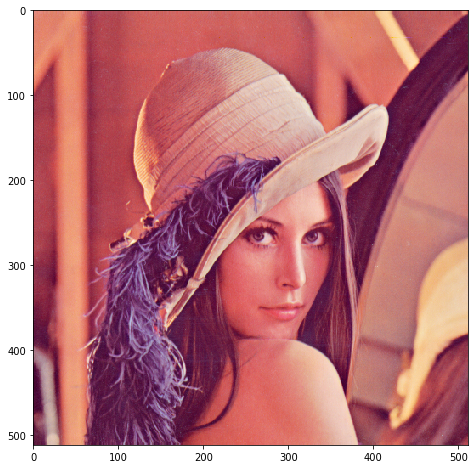

In [0]:
!rm Lena.png
!wget http://deeplearning.iit.bme.hu/Lena.png
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('Lena.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB).reshape((img.shape[0],img.shape[1]*3))
np.savetxt('lena.csv',img,delimiter=',',fmt='%d')
plt.figure(figsize=(8,8))
plt.imshow(img.reshape((img.shape[0],img.shape[1]//3,3)))

## GrayScale Conversion

In [0]:
%%cu
#include <iostream>
#include <fstream>
#include <sstream>

// Texture to store our image
texture< uchar4, 2, cudaReadModeElementType > image;

// Kernel
__global__ void grayscale( unsigned char* result, int width )
{
    // Now, we have 2D arrays, so 2 indices
    int ix = blockDim.x * blockIdx.x + threadIdx.x;
    int iy = blockDim.y * blockIdx.y + threadIdx.y;
 
    // Get pixel from texture
    uchar4 pixel = tex2D( image, (float)ix, (float)iy );
 
    // Compute grayscale value
    float value = 0.3 * pixel.x + 0.59 * pixel.y + 0.11 * pixel.z;
 
    // Write output
    result[iy*width + ix] = value;
}

// Read csv
void readCsv(std::string fname, unsigned char* imData)
{
    // File pointer 
    std::fstream fin; 
  
    // Open an existing file 
    fin.open(fname, std::ios::in);
 
    // Vars
    std::string line, word; 
 
    // Counter
    int i = 0;
  
    // While there are lines
    while (std::getline(fin, line)) { 
  
        // used for breaking words 
        std::stringstream s(line); 
  
        // read every column data of a row and 
        // store it in a string variable, word 
        while (getline(s, word, ',')) { 
            
            // String to integer
            imData[i++] = std::stoi(word);
            
            // Add a 0 value to every 4th position (needed because we have uchar4 texture)
            if (i%4 == 3)
                imData[i++] = 0;
        }
    }
}

// Write csv
void writeCsv(std::string fname, unsigned char* imData, int width, int height)
{
    // File pointer 
    std::fstream fout; 
  
    // Open a new file 
    fout.open(fname, std::ios::out);
  
    for( int i = 0; i < height; i++)
    {
        int offs = width * i;
     
        for (int j = 0; j < width; j++)
        {
            // Write value (float conversion needed to aviod writing chars as ascii)
            fout << float(imData[offs+j]);
         
            // Avoid writing comma after last value in row (causes errors later)
            if (j < width-1) 
                fout << ",";
        }
     
        fout << std::endl;
    }
}

int main()
{
    // Basic variables
    unsigned char *imData;
    int width = 512;
    int height = 512;
    int ch = 4;
    
    // Read image
    int size = width * height * sizeof( unsigned char );    
    imData = (unsigned char *)malloc(size * ch);
    readCsv("lena.csv",imData);

    // Create channel descriptor
    cudaChannelFormatDesc channelDesc = cudaCreateChannelDesc<uchar4>();
 
    // Allocate GPU array and copy image
    cudaArray* cu_array;
    cudaMallocArray( &cu_array, &channelDesc , width, height );
    cudaMemcpyToArray( cu_array, 0, 0, imData, size*ch, cudaMemcpyHostToDevice);
 
    // Set texture parameters
    image.addressMode[0] = cudaAddressModeWrap; // Wrap if indexing out
    image.addressMode[1] = cudaAddressModeWrap;
    image.filterMode = cudaFilterModePoint; // No filtering
    image.normalized = false; // Use array index 
    cudaBindTextureToArray( image, cu_array, channelDesc ); // Bind array
 
    // Allocate output
    unsigned char *result, *result_cpu;
    cudaMalloc((void **)&result, size); 
    result_cpu = (unsigned char *)malloc(size);

    // Call kernel
    dim3 dimBlock( 8, 8, 1 ); 
    dim3 dimGrid( width >> 3, height >> 3, 1 ); 
    grayscale<<< dimGrid , dimBlock >>>( result, width );
 
    // Copy result from GPU and save
    cudaMemcpy(result_cpu, result, size, cudaMemcpyDeviceToHost);
    writeCsv("lena_gray.csv",result_cpu,width,height);

    // Cleanup
    cudaFreeArray( cu_array );
    cudaFree( result );
}

### Display

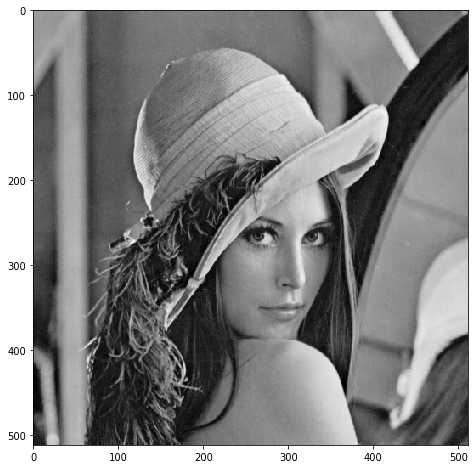

In [0]:
# Show image
img = np.loadtxt("lena_gray.csv",delimiter=",").astype('uint8')
plt.figure(figsize=(8,8))
plt.imshow(img,cmap='gray')

### Create Noisy image

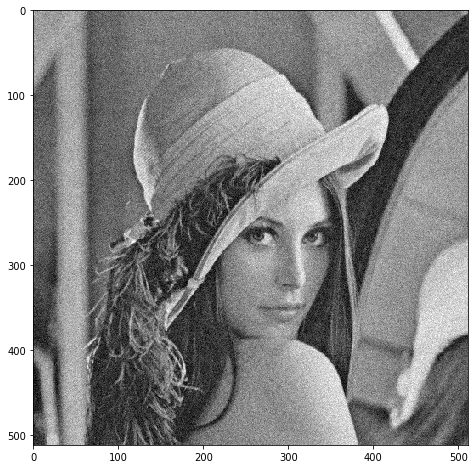

In [0]:
# Add noise to the image
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        sigma = 15
        # Create random gaussian
        gauss = np.random.normal(mean,sigma,(row,col))
        # Make sure it has the same shape
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        noisy = np.clip(noisy,0,255)
        return noisy
    elif noise_typ == "snp":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.02
        out = np.copy(image)
        # Number of salt (half of total)
        num_salt = np.ceil(amount * image.size * s_vs_p)
        # Random locations
        coords = tuple([np.random.randint(0, i - 1, int(num_salt)) for i in image.shape])
        out[coords] = 255

        # Number of pepper (half of total)
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        # Random locations
        coords = tuple([np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape])
        out[coords] = 0
        return out

img_noise = noisy("gauss",img)
np.savetxt('lena_noisy.csv',img_noise,delimiter=',',fmt='%d')
plt.figure(figsize=(8,8))
plt.imshow(img_noise,cmap='gray')

## Convolution

In [0]:
%%cu
#include <iostream>
#include <fstream>
#include <sstream>

// GrayScale texture
texture< uchar1, 2, cudaReadModeElementType > image;

// Helper function to get a single weighted pixel
// __device__ means this is a kernel called from within a kernel
__device__ float getWPixel( int ix, int iy, int dx, int dy, float* cmtx )
{
    // Get pixel value
    uchar1 pixel = tex2D( image, (float)(ix+dx), (float)(iy+dy) );
 
    // Get kernel value
    float cmul = cmtx[ 3 * ( 1 - dy ) + 1 - dx ];
 
    // Return product
    return pixel.x * cmul;
}

// Conv kernel
__global__ void convolve ( unsigned char* result, int width, float* cmtx )
{
    // 2D indexing
    int ix = blockDim.x * blockIdx.x + threadIdx.x;
    int iy = blockDim.y * blockIdx.y + threadIdx.y;
 
    // Add 9 weighted pixels
    float pixel = 
    getWPixel( ix, iy, -1, -1, cmtx ) + getWPixel( ix, iy, -1, 0, cmtx ) + getWPixel( ix, iy, -1, 1, cmtx )
    + getWPixel( ix, iy, 0, -1, cmtx ) + getWPixel( ix, iy, 0, 0, cmtx ) + getWPixel( ix, iy, 0, 1, cmtx )
    + getWPixel( ix, iy, 1, -1, cmtx ) + getWPixel( ix, iy, 1, 0, cmtx ) + getWPixel( ix, iy, 1, 1, cmtx );
 
    // Write result
    result[ iy * width + ix ] =  pixel;
}

// Read csv
void readCsv(std::string fname, unsigned char* imData)
{
    // File pointer 
    std::fstream fin; 
  
    // Open an existing file 
    fin.open(fname, std::ios::in);
 
    // Vars
    std::string line, word; 
 
    // Counter
    int i = 0;
  
    // While there are lines
    while (std::getline(fin, line)) { 
  
        // used for breaking words 
        std::stringstream s(line); 
  
        // read every column data of a row and 
        // store it in a string variable, word 
        while (getline(s, word, ',')) { 
            
            // String to integer
            imData[i++] = std::stoi(word);
        }
    }
}

// Write csv
void writeCsv(std::string fname, unsigned char* imData, int width, int height)
{
    // File pointer 
    std::fstream fout; 
  
    // Open a new file 
    fout.open(fname, std::ios::out);
  
    for( int i = 0; i < height; i++)
    {
        int offs = width * i;
     
        for (int j = 0; j < width; j++)
        {
            // Write value (float conversion needed to aviod writing chars as ascii)
            fout << float(imData[offs+j]);
         
            // Avoid writing comma after last value in row (causes errors later)
            if (j < width-1) 
                fout << ",";
        }
     
        fout << std::endl;
    }
}


int main()
{
    // Basic variables
    unsigned char *imData;
    int width = 512;
    int height = 512;
    int ch = 1;
    
    // Read image
    int size = width * height * sizeof( unsigned char );    
    imData = (unsigned char *)malloc(size * ch);
    readCsv("lena_noisy.csv",imData);

    // Create channel descriptor
    cudaChannelFormatDesc channelDesc = cudaCreateChannelDesc<uchar1>();
 
    // Allocate GPU array and copy image
    cudaArray* cu_array;
    cudaMallocArray( &cu_array, &channelDesc , width, height );
    cudaMemcpyToArray( cu_array, 0, 0, imData, size*ch, cudaMemcpyHostToDevice);
 
    // Set texture parameters
    image.addressMode[0] = cudaAddressModeWrap; // Wrap if indexing out
    image.addressMode[1] = cudaAddressModeWrap;
    image.filterMode = cudaFilterModePoint; // No filtering
    image.normalized = false; // Use array index 
    cudaBindTextureToArray( image, cu_array, channelDesc ); // Bind array
 
    // Create filter
    float filt[9] = {1.0/9.0,1.0/9.0,1.0/9.0,
                     1.0/9.0,1.0/9.0,1.0/9.0,
                     1.0/9.0,1.0/9.0,1.0/9.0};
    
    // Copy filter to GPU
    float *cmtx;
    cudaMalloc((void **)&cmtx, 9*sizeof(float)); 
    cudaMemcpy(cmtx, filt, 9*sizeof(float), cudaMemcpyHostToDevice);
 
    // Allocate output
    unsigned char *result, *result_cpu;
    cudaMalloc((void **)&result, size); 
    result_cpu = (unsigned char *)malloc(size);

    // Call kernel
    dim3 dimBlock( 8, 8, 1 ); 
    dim3 dimGrid( width >> 3, height >> 3, 1 ); 
    convolve<<< dimGrid , dimBlock >>>( result, width, cmtx );
 
    // Copy result from GPU and save
    cudaMemcpy(result_cpu, result, size, cudaMemcpyDeviceToHost);
    writeCsv("lena_filt.csv",result_cpu,width,height);

    // Cleanup
    cudaFreeArray( cu_array );
    cudaFree( result );
}


## Display

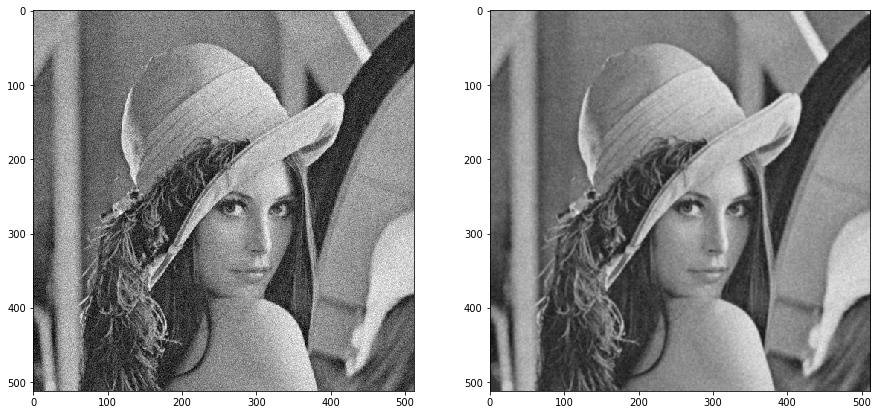

In [0]:
img_filt = np.loadtxt("lena_filt.csv",delimiter=",").astype('uint8')
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img_noise,cmap='gray',norm=plt.Normalize(0,255))
plt.subplot(1,2,2)
plt.imshow(img_filt,cmap='gray',norm=plt.Normalize(0,255))